# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# initialize_parameters(layer_dims) function

Generate random weights and biased for each layer (except input layer)


In [2]:
def initialize_parameters(linear_dims):
    dic = {}           #Dictionary to save the weights and biased for each layer 
  
    for k in range(1, len(linear_dims)):   #loop start with 1 end with Length of the NN
        dic['W'+str(k)]= np.random.randn(linear_dims[k], linear_dims[k-1]) #generate random array
        dic['b'+str(k)]= np.zeros((linear_dims[k], 1))    #generate random array of size(layer size ,1)
        
    return dic

# Activation functions

In [3]:
def sigmoid(Z):      #input z===> linear output(wx+b)
    A = 1/(1+np.exp(-Z))     
    return A         #output A===> sigmoid of the linear output(sig(wx+b))


def relu(Z):          #input z===> linear output(wx+b)
    A = np.maximum(0,Z)
    return A          #output A===> relu of the linear output(max(0,wx+b))

def sigmoid_backward(dA, cache):              #input dA===> derv of linear
    Z = cache                                     #input cache===>   A,w,b
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ                     #output dZ===> derivative of sigmoid ==> d(sig(linear))

def relu_backward(dA, cache):                   #input dA===>derv of linear
    Z = cache                                   #input cache===>   A,w,b
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ                                 #output dZ===> derivative of relu==> d(max(0,wx+b)) 
                                              #at x=-ve===>der(f(x))=0........at x=+ve===>der(f(x))=1



# <font color='red'>1)Forward Path</font>

# linear_forward(A, W, b) one time function

Take the input matrix,Weight matrix ,biased matrix (generated from initialize_parameters)
and Generate the dot product (WX+b)

In [4]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b        #dot product (WX+b)
    cache = (A, W, b)           #save the input matrix ,weight matrix ,biased matrix
    return Z, cache

# activation_forward(A_prev, W, b, activation_fn) one time function 
Take the input matrix,Weight matrix ,biased matrix (generated from initialize_parameters)
and Generate the Non linearity(pass the output to an activation function)

In [5]:
def activation_forward(A_prev, W, b, activation_fn):
  

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = sigmoid(Z)


    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = relu(Z)

    cache = (linear_cache, Z)
    return A, cache

# model_forward(X, parameters)
Function for feed forward model of NN
Take the input matrix , init_Parameters and Generate the output(Y_HAT)

In [6]:
def model_forward(X, parameters):
    A = X                           
    caches = []                     
    L = len(parameters) // 2         # number of layers in the neural network               
    
#from input layer to lastlayer-1
    for k in range(1, L):
        A_prev = A                                   #store  A_prev (output from the previous layer)
        A, cache = activation_forward(               #store (output from the dot product of A_prev) in A 
            A_prev, parameters["W" + str(k)], parameters["b" + str(k)],
            activation_fn="relu")                    #store each layer (x,w,b) in the caches list as a list(multi-lists)
        caches.append(cache)
        
#last layer(output layer)
    AL, cache =activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)
    return AL, caches

# compute_cost function 
compute the total cost of all samples after one forward pass (epoc)



In [7]:
def compute_cost(AL, y):
    m = y.shape[1]            #number of labeled data records (truth) 
    j = - (1 / m) * np.sum(np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return j


 #  <font color='red'> 2)Backward</font>


# linear_backword(dZ, cache) 
### calculate the partial derivatives (∂L/∂A_prev) , (∂L/∂W) and (∂L/∂b) for a single layer 
dz : derivative of the activated output respect to linear output(∂L/∂Z)....................
cache: is (A_prev, W, b)


In [8]:
def linear_backword(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1] #number of inputs 

    dW = (1 / m) * np.dot(dZ, A_prev.T)  # ∂L/∂W
    db = (1 / m) * np.sum(dZ)            # ∂L/∂b
    dA_prev = np.dot(W.T, dZ)            # ∂L/∂A
    
    return dA_prev, dW, db 

# activation_backward(dA, cache, activation_fn)
### connect the 2 backward functions to calculate the partial derivatives  (∂output/∂A),(∂output/∂W) and (∂output/∂b) for a single layer 

In [9]:
def activation_backward(dA, cache, activation_fn):   #dA=derivative of linear
    linear_cache, activation_cache = cache           #cache before activation and after

    if activation_fn == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)         #get the derivative of the sigmoid function ∂L/∂Z
        dA_prev, dW, db = linear_backword(dZ, linear_cache) #use this derivative to get(∂L/∂A_prev),(∂L/∂W) and(∂L/∂b)

    elif activation_fn == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db

# model_backward(AL, Y, caches): Implement the backward propagation
### ( Al: the final output from the forward propagation)................(Y :Label Data)................(caches:Cache of forward)
### calculate the all partial derivatives

In [10]:
def model_backward(AL, Y, caches):
    grads = {} #DICT to store all partial derivatives
    L = len(caches)          # number of layers in the NN
    Y = Y.reshape(AL.shape)  #make the truth label same shape as the output
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))   #∂L(loss)/∂AL(yhat)= -((Y/AL)-((1-Y)/(1-AL)))
    
    
    current_cache = caches[L-1] #the last cache
    #one step to get the last ∂L/∂A ,∂L/∂W ,∂L/∂b 
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, "sigmoid")
    
    
    #loop start from the last layer-1
    for k in reversed(range(L-1)):
        current_cache = caches[k]
          #store the whole  ∂L/∂A ,∂L/∂W ,∂L/∂b
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(k + 1)], current_cache,"relu")
        grads["dA" + str(k)] = dA_prev_temp
        grads["dW" + str(k + 1)] = dW_temp
        grads["db" + str(k + 1)] = db_temp

    return grads

# Update_parameters(parameters, grads, learning_rate):
## update the parameter values (w,b)
###  w=w-alpha*dL/dw

In [11]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers in the neural network
    #loop with parameter length to update each parameter(w,b)
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)] # w=w-alpha*dL/dW
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)] # b=b-alpha*dL/db
    return parameters

#  <font color='red'> 3) MODEL BUILD </font>

In [12]:
def Model(X, y, layers_dims, learning_rate, num_iterations,hidden_layers_activation_fn):
 #whole NN model contain forward , backward and update parameters   
    
 #x===>inputs
 #y===>label truth
 #layers_dims===> number of perceptrone in each layer
 #learning_rate===> step size
 #hidden_layers_activation_fn===> used activation


    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost ,epoc list
    cost_list = []
    epoc_list=[]
    
    # iterate over num_iterations
    for i in range(num_iterations):
        
        # iterate over L-layers to get the final output and the cache
        AL, caches = model_forward(X, parameters)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = model_backward(AL, y, caches)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        cost_list.append(cost)
        epoc_list.append(i)
         
        print("The cost after ",(i + 1),"epoc is: ",cost_list[i])

        
    
    return parameters,cost_list,epoc_list

# <font color='red'> 4) TRAIN AND TEST THE MODEL</font>

# DATA PREPARATION

In [13]:
data=pd.read_csv("Train_data.csv") #Read the data set
data=pd.DataFrame(data)            #Frame the data set
print(data)


X=np.array(data.drop(columns =["Labels"], inplace = False))
X = X.reshape(97, -1).T   #to be in shape of (13, 97)
y=np.array(data["Labels"])   
y= y.reshape(-1, 97)     #to be in shape of (1, 97)


#Normalize the data
X= X / 255 



#split the data into Train and Test
y_train=y[:,0:80]
X_train=X[:,0:80]

y_test=y[:,81:]
X_test=X[:,81:]


       F1    F2    F3    F4   F5    F6    F7    F8    F9   F10   F11   F12  \
0   14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04  3.92   
1   13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
2   13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
3   14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
4   13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   
..    ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
92  12.72  1.75  2.28  22.5   84  1.38  1.76  0.48  1.63  3.30  0.88  2.42   
93  12.22  1.29  1.94  19.0   92  2.36  2.04  0.39  2.08  2.70  0.86  3.02   
94  11.61  1.35  2.70  20.0   94  2.74  2.92  0.29  2.49  2.65  0.96  3.26   
95  11.46  3.74  1.82  19.5  107  3.18  2.58  0.24  3.58  2.90  0.75  2.81   
96  12.52  2.43  2.17  21.0   88  2.55  2.27  0.26  1.22  2.00  0.90  2.78   

     F13  Labels  
0   1065       0  
1   1050       0  
2   11

# Forward-path 

In [14]:
AL, caches=model_forward(X_train, initialize_parameters([X_train.shape[0], 5, 5, 1]))


# Backward-path 

In [15]:
graad=model_backward(AL, y_train, caches)
graad

{'dA2': array([[ 1.61118944,  1.61323091,  1.62432333,  1.63579309,  1.52389985,
          1.63524433,  1.6306688 ,  1.62988914,  1.61185696,  1.61144921,
          1.63645126,  1.63014292,  1.63201379,  1.62289562,  1.63718961,
          1.63085688,  1.62889969,  1.6186742 ,  1.63851739,  1.56927881,
          1.54234044,  1.54636872,  1.61004628,  1.60813013,  1.57196364,
          1.55840196,  1.62579003,  1.63048424,  1.58764118,  1.61064111,
          1.62968872,  1.63651274,  1.60308362,  1.62603554,  1.61605093,
          1.58938232,  1.58071481,  1.61827111,  1.60879848,  1.53586135,
          1.55098417,  1.61085454,  1.61709979,  1.50429252, -0.22854232,
         -0.13074506, -0.3198654 , -0.16194411, -0.35145922, -0.44839533,
         -0.13509659, -0.25230013, -0.24683017, -0.10262124, -0.134252  ,
         -0.06193066, -0.37613097, -0.29957294, -0.04662518, -0.05809252,
         -0.33972899, -0.37956969, -0.27528325, -0.11138243, -0.31867547,
         -0.54807165, -0.113177

# Model-run and cost calculation

In [16]:
# make layers dims
layers_dims = [X_train.shape[0],5,5,1]

# Whole NN with sigmoid activation fn
param,c_l,e_l=Model( X_train, y_train,layers_dims , 0.01, 3000,"sigmoid")


The cost after  1 epoc is:  0.8786149038353692
The cost after  2 epoc is:  0.8634101987161067
The cost after  3 epoc is:  0.8460923967236635
The cost after  4 epoc is:  0.8317504997322032
The cost after  5 epoc is:  0.8184892919485697
The cost after  6 epoc is:  0.8057525794099485
The cost after  7 epoc is:  0.7952677785960355
The cost after  8 epoc is:  0.7829043420409939
The cost after  9 epoc is:  0.7723840469051811
The cost after  10 epoc is:  0.7624807875639905
The cost after  11 epoc is:  0.7531406279758353
The cost after  12 epoc is:  0.7443556620712841
The cost after  13 epoc is:  0.7360187712654084
The cost after  14 epoc is:  0.7281096786105669
The cost after  15 epoc is:  0.7207722618275182
The cost after  16 epoc is:  0.7150695342483439
The cost after  17 epoc is:  0.7140988051439847
The cost after  18 epoc is:  0.7142158522206533
The cost after  19 epoc is:  0.7043374336835831
The cost after  20 epoc is:  0.6925441373564909
The cost after  21 epoc is:  0.6857404772248971
T

# Cost-Plot

Text(0.5, 1.0, 'Cost-Plot')

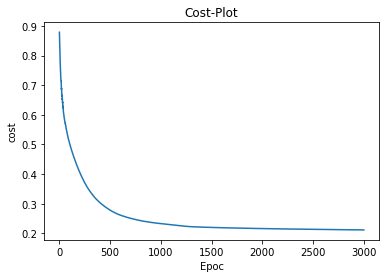

In [17]:
plt.plot(e_l,c_l)
plt.xlabel("Epoc")
plt.ylabel("cost")
plt.title("Cost-Plot")

# Model-Predection

In [18]:
def predict(X):
    AL,CASHES =model_forward(X,param)
    prediction=[]
    for i in range(0, AL.shape[1]):
        
        if AL[0,i] > 0.5:
            prediction.append(1)
        else:
            prediction.append(0)
    return(prediction)

In [19]:
predict(np.array(X_test))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
def accuracy(Y,Y_HAT):
    lis=[]
    for i in range(Y.shape[1]):
        if Y[0,i]==Y_HAT[i]:
            lis.append(1)
        else:
            lis.append(0)
    return (np.sum(lis)/Y.shape[1])        
            

In [21]:
accuracy(y_test,np.array(predict(X_test)))

1.0